# Preliminary operation and Import Packages

2.9 version of TensorFlow/Keras, because some data augmentation techniques are particularly slow

In [ ]:
%pip install tensorflow-gpu==2.8.3 
%pip install -U scikit-learn

In [ ]:
!nvidia-smi

Mon Feb  6 21:40:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |    214MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3053378521526046220
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2118325974425920900
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import regularizers
from tensorflow import initializers
from keras.layers import LSTM
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Activation

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Image management
import cv2

from time import time
import sys
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils import class_weight 

import pydot
import pydotplus
from pydotplus import graphviz

In [ ]:
# Set the directory where the label  is stored

# path = 'C:/Users/marco/Desktop/Local_Documents/data'
# os.chdir(path=path)

In [ ]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [10,10] # width, height

## *Original images generator[OLD]

In [ ]:
target_size = (224,224) # Target size
batch_size = 64 # Batch size

train_path = 'C:/Users/marco/Desktop/Local_Documents/data/train/'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/test/'   

train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
os.chdir(train_path)

#Training set
train_data = train_datagen.flow_from_dataframe(
dataframe=train_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

In [ ]:
os.chdir(train_path)

# Validation set
validation_data = test_datagen.flow_from_dataframe(
dataframe=val_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 1650 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 17 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
os.chdir(test_path)

# Test set
test_data = test_datagen.flow_from_dataframe(
dataframe=test_label,
directory=test_path,
x_col="img_path",
y_col=None,
batch_size=batch_size,
seed=123,
shuffle=False,
class_mode=None,
target_size=target_size)

Found 400 validated image filenames.


In [ ]:
class_names = train_data.class_indices
print(class_names)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


# Models

In [ ]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
version = "v2"
arc = "a1"
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/cnn_model__fs_{version}_{arc}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## 1. CNN from scratch

-  Downsample dataset
- No image processing
- No data Augmentation
- 30 epochs 

In [ ]:
num_classes = 3

In [ ]:
# Architecture definition
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_cnn_1 = keras.Model(inputs, outputs)

In [ ]:
net_cnn_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 75, 75, 64)        0         
                                                           

In [ ]:
keras.utils.plot_model(net, to_file=f'C:/Users/marco/Desktop/Local_Documents/model/plot/{version}/cnn_schema_fs_{version}_{arc}.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Compile the model for training
net_cnn_1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history_cnn_1 = net_cnn_1.fit_generator(train_data,
          epochs=100,
          validation_data=validation_data,
          workers = 1,
          callbacks=[model_checkpoint_callback, early_stopper])

C:\Users\marco\AppData\Local\Temp\ipykernel_10784\4285332846.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn_1 = net_cnn_1.fit_generator(train_data,


Epoch 1/100
233/233 [==============================] - 333s 1s/step - loss: 0.7790 - accuracy: 0.6741 - val_loss: 0.6462 - val_accuracy: 0.7170
Epoch 2/100
233/233 [==============================] - 372s 2s/step - loss: 0.6023 - accuracy: 0.7547 - val_loss: 0.5813 - val_accuracy: 0.7570
Epoch 3/100
233/233 [==============================] - 355s 2s/step - loss: 0.5538 - accuracy: 0.7715 - val_loss: 0.5648 - val_accuracy: 0.7558
Epoch 4/100
233/233 [==============================] - 345s 1s/step - loss: 0.5268 - accuracy: 0.7833 - val_loss: 0.5523 - val_accuracy: 0.7745
Epoch 5/100
233/233 [==============================] - 344s 1s/step - loss: 0.5053 - accuracy: 0.7952 - val_loss: 0.5375 - val_accuracy: 0.7782
Epoch 6/100
233/233 [==============================] - 344s 1s/step - loss: 0.4896 - accuracy: 0.8038 - val_loss: 0.5114 - val_accuracy: 0.7921
Epoch 7/100
233/233 [==============================] - 356s 2s/step - loss: 0.4722 - accuracy: 0.8077 - val_loss: 0.4993 - val_accuracy:

In [ ]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/cnn_1_fs_{version}_{arc}.npy',
        history_cnn_1.history)

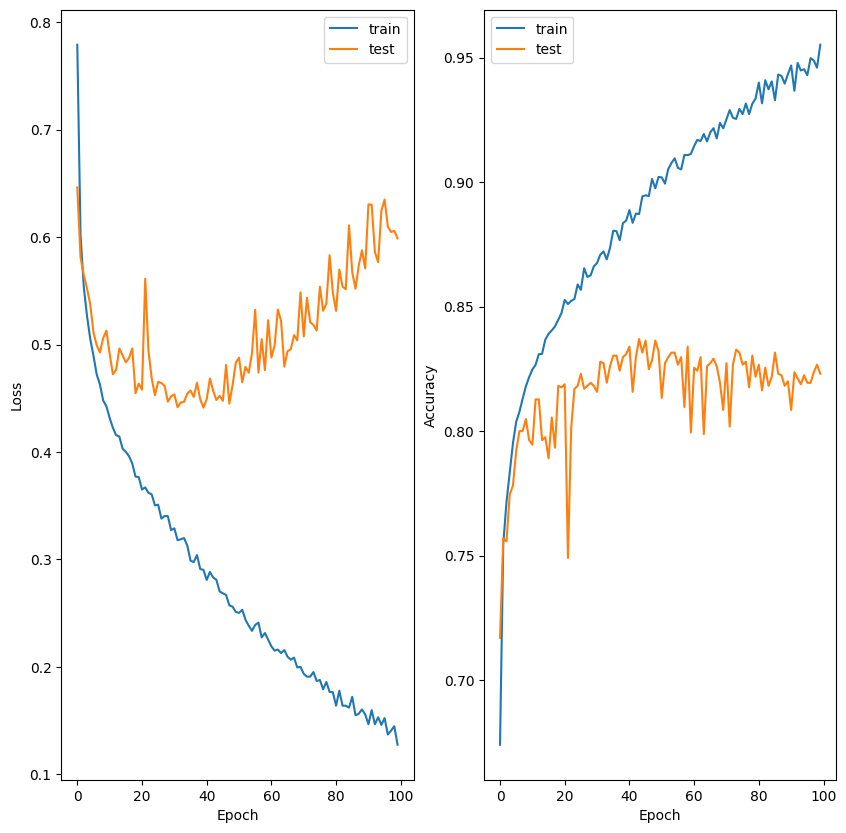

In [ ]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_cnn_1.history['loss'])
plt.plot(history_cnn_1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_1.history['accuracy'])
plt.plot(history_cnn_1.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

## 2. CNN from scratch w\AGC

-  Downsample dataset
- Adaptive Gamma Correction
- No data Augmentation
- 30 epochs 

In [ ]:
num_classes = 3

In [ ]:
# Architecture definition
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_cnn_gc = keras.Model(inputs, outputs)

In [ ]:
net_cnn_gc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 75, 75, 64)        0         
                                                             

In [ ]:
# Compile the model for training
net_cnn_gc.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
history_cnn_agc = net_cnn_gc.fit_generator(train_gc,
          epochs=100,
          validation_data=validation_data_gc,
          workers = 1,
          callbacks=[model_checkpoint_callback, early_stopper])

C:\Users\marco\AppData\Local\Temp\ipykernel_36888\3744893962.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn_agc = net_cnn_gc.fit_generator(train_gc,


Epoch 1/100
166/166 [==============================] - 158s 949ms/step - loss: 0.8984 - accuracy: 0.5704 - val_loss: 0.8392 - val_accuracy: 0.6414
Epoch 2/100
166/166 [==============================] - 158s 949ms/step - loss: 0.8085 - accuracy: 0.6494 - val_loss: 0.7974 - val_accuracy: 0.6597
Epoch 3/100
166/166 [==============================] - 158s 949ms/step - loss: 0.7785 - accuracy: 0.6609 - val_loss: 0.7732 - val_accuracy: 0.6681
Epoch 4/100
166/166 [==============================] - 158s 949ms/step - loss: 0.7593 - accuracy: 0.6699 - val_loss: 0.7544 - val_accuracy: 0.6772
Epoch 5/100
166/166 [==============================] - 157s 946ms/step - loss: 0.7429 - accuracy: 0.6772 - val_loss: 0.7412 - val_accuracy: 0.6930
Epoch 6/100
166/166 [==============================] - 159s 957ms/step - loss: 0.7301 - accuracy: 0.6874 - val_loss: 0.7263 - val_accuracy: 0.6947
Epoch 7/100
166/166 [==============================] - 158s 952ms/step - loss: 0.7158 - accuracy: 0.6952 - val_loss: 0

In [ ]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/cnn_gc_fs_{version}_{arc}.npy',
        history_cnn_1.history)

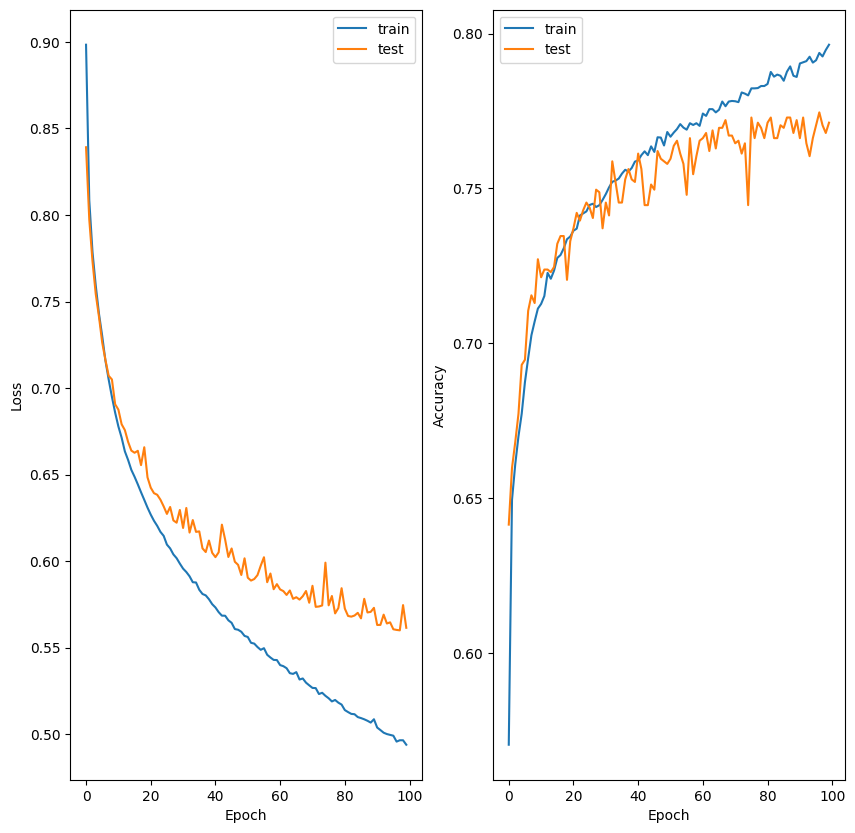

In [ ]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_cnn_agc.history['loss'])
plt.plot(history_cnn_agc.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_agc.history['accuracy'])
plt.plot(history_cnn_agc.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

L'applicazione dell'algoritmo Adaptive Gamma correction ha portato ad un miglioramento dei risultato, in termini di contenimento dell'overfitting. Si procede quindi considerando questo tipo di soluzione.